### Exploritory Data Analysis:

**After I have done the basic data clean-up it was time to explore the data using different analytical plots. 
EDA is very important because it allows me to explore deeper into the dataset and find important quantities, features, and correlations. With the help of these findings not only would I be able to supply my future machine learning models with higher data quality but also, reinforce one's knowledge on the general performance of the product to which the data is related to**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#importing the data
movie_metadata = pd.read_csv("movies_md.csv")
ratings = pd.read_csv("ratings_nw.csv")

In [3]:
#creating copies of the data sets
mmd = movie_metadata.copy()
rts = ratings.copy()

In [4]:
#renaming the 'id' column to 'movieId' for convenience
mmd.rename(columns={"id": "movieId"}, inplace=True)

In [5]:
#Merging ratings and movie_metadata data on 'movieId' column 
movie_data = pd.merge(rts, mmd, on='movieId')

In [6]:
movie_data.shape

(11436568, 6)

In [7]:
movie_data.head()

,userId,movieId,rating,timestamp,genres,title
0,1,110,1.0,1425941529,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
1,11,110,3.5,1231676989,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
2,22,110,5.0,1111937009,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
3,24,110,5.0,979870012,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
4,29,110,3.0,1044020005,"['Drama', 'Mystery', 'Romance']",Three Colors: Red


In [8]:
# Basic Analysis 
T = len(rts['userId'].unique()) # Total number of registered users
TA = len(movie_data['userId'].unique()) # Total number of active users
C = movie_data['rating'].mean() # Global average rating   
AM = len(mmd['title'].unique()) # Total amount of movies on the platform
WAM = len(movie_data['title'].unique()) # Amount of movies watched atleast by 1 user (has atleast 1 vote)
TV = movie_data['userId'].count() # Total number of votes 
MGR1 = movie_data.groupby('userId')['rating'].count().max() # Maximum votes given by a user
MGR2 = movie_data.groupby('userId')['rating'].count().min() # Minimum votes given by a user

print("Total number of registered users: {}".format(T))
print("Total number of active users: {}".format(TA))
print("Global average rating: {:.2f}".format(C))
print("Total amount of movies on the platform: {}".format(AM))
print("Total amount of movies with atleast 1 vote: {}".format(WAM))
print("Total number of registered votes: {}".format(TV))
print("Maximum votes given by a user {}".format(MGR1))
print("Minimum votes given by a user {}".format(MGR2))

Total number of registered users: 270896
Total number of active users: 265917
Global average rating: 3.53
Total amount of movies on the platform: 42277
Total amount of movies with atleast 1 vote: 7409
Total number of registered votes: 11436568
Maximum votes given by a user 3593
Minimum votes given by a user 1


#### Insights:
**1.** There are 4979 users that did not vote<br>
**2.** The overall movie quality is above average and/or users are pretty generous when it comes to rating<br>
**3.** Each active user voted 40 times on average<br>
**4.** Only 17% of movies on the platform have atleast 1 vote

In [9]:
# Advanced Analysis 
# creating a new dataframe which consists of movie titles, average rating for the movie and total number of votes for the movie
ratings_avg_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_avg_count['number_of_votes'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_avg_count.reset_index(inplace=True)
ratings_avg_count.head()

,title,rating,number_of_votes
0,!Women Art Revolution,2.802945,883
1,"$1,000 on the Black",3.000000,1
2,$5 a Day,2.246795,156
3,'Gator Bait,3.443590,195
4,'R Xmas,2.627907,86


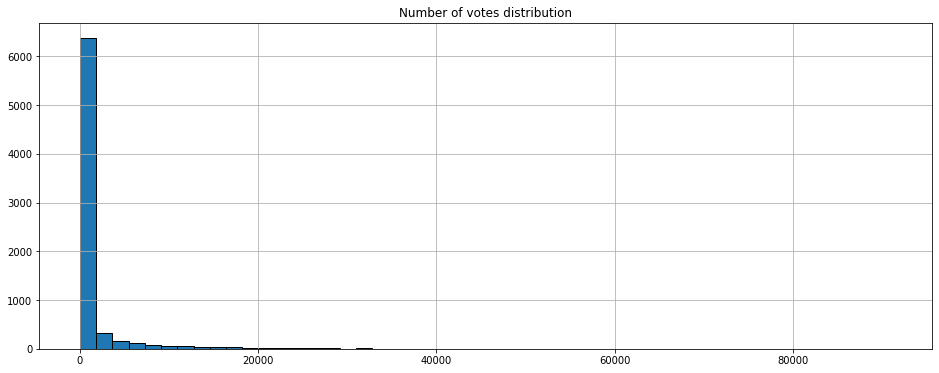

In [10]:
plt.figure(figsize=(16,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['number_of_votes'].hist(bins=50)
plt.title("Number of votes distribution")
plt.show()

**Most of the movies on the platform have around 50 votes**

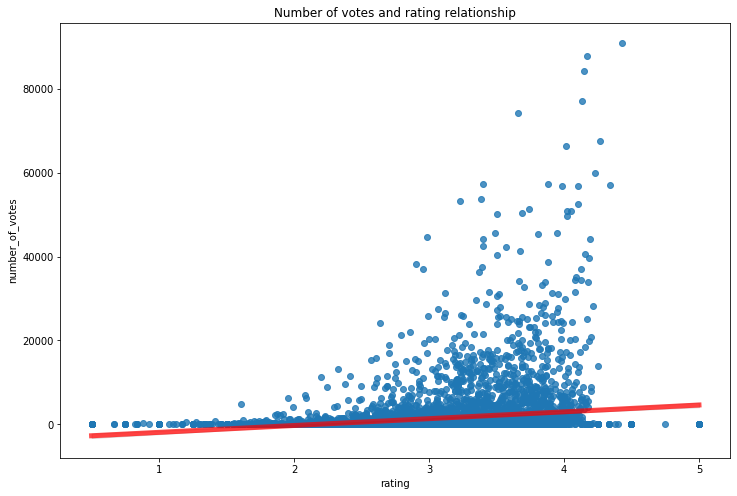

In [11]:
plt.figure(figsize=(12,8))
sns.regplot(x='rating', y='number_of_votes',data=ratings_avg_count, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title("Number of votes and rating relationship")
plt.show()

**There is a slight positive correlation between the average rating of a movie and the number of votes. According to the graph:<br> 1. Movies with higher average ratings actually have more number of ratings.**<br>
**2. If a movie gets more number of votes, the average rating would increase slightly**

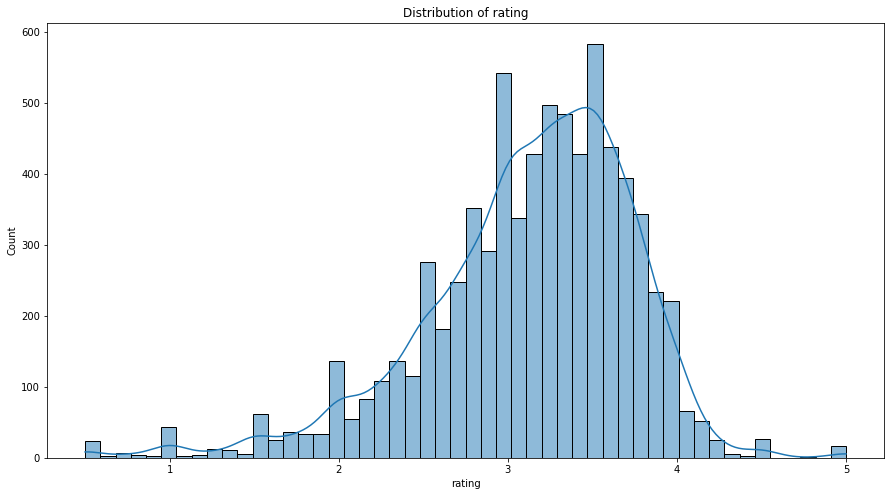

In [12]:
plt.figure(figsize=(15,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_avg_count, x="rating",bins=50, kde=True)
plt.title("Distribution of rating")
plt.show()

**According to the graph the data has a weak normal distribution with the mean around 3.5 due to the presence of outliers in the data. In addition, values of format x and x.5 (where x is a number between 0 - 5) are assigned by users much more often than other float values**

## Creating a Top 10 Movie List <a id='metric'></a>

**In order to create a top 10 movie list I will use IMDb's formula for computing the movie's weighted rate and use it as the movie's score.** <br>

### Why IMDb's Formula?



### The Formula:

**WR = (v/(v+m)) * R + (m/(v+m)) * C** 

*Where:*

**R** = Average for the movie as a number from 0.5 - 5<br>
**v** = Number of votes for the movie<br>
**m** = Minimum votes required to be listed in the top 250 (according to imdb: 25,000)<br>
**C** = The mean vote across the whole report 

### Finding  m for MovieLens platform:

**I cannot use the m value of IMDb because:**<br>
1. It is a threshold for top 250 movies. <br>
2. IMDb has 83 million users while while the platform has 270,000.<br>

**As a result, I need to scale it to be suitable for the amount of users which are on the MovieLens platform.**

**1.** Find the ratio between total number of users on IMDb (Tu1) and (m1): 83,000,000 : 25,000 --> [3320 : 1].<br> 
**2.** Find the ratio between total number of users on the platform (Tu2) and (m2) : m2 : 270,896. <br>
**3.** Compare both ratios and solve the equation for m2: 3320 * m2 = 270,896 * 1 --> **m2 = 82**. <br>

**Now that I have the minimum votes required to be listed in the top 250 in the MovieLens platform I can calculate the weighted rate for each movie, create the a list of top 250 by filtering all the movies which have less than 82 votes and lastly from that list creating another list of Top 10 movies**

### Calculation

In [13]:
#Creating m, C 
m = 82
C = 3.53

#I filter the movies with less than 82 votes
filtered_movies = ratings_avg_count.loc[ratings_avg_count['number_of_votes'] >= m]

#creating a function that will compute the rating for each movie
def weighted_rate(data, m=m, C=C):
    R = data['rating']
    v = data['number_of_votes']
    wr =  (v/(v+m) * R) + (m/(m+v) * C)
    return wr

filtered_movies['weighted_rate'] = filtered_movies.apply(weighted_rate, axis=1)
filtered_movies = filtered_movies.sort_values('weighted_rate', ascending=False)
filtered_movies = filtered_movies.head(250)

### Top 10 Movies with adjusted IMDb metric:

In [14]:
filtered_movies.head(10)

,title,rating,number_of_votes,weighted_rate
6107,The Million Dollar Hotel,4.429015,91082,4.428206
4825,Sleepless in Seattle,4.339811,57070,4.338649
3930,Once Were Warriors,4.266531,67662,4.265639
2336,Hard Target,4.255074,13994,4.250850
3160,License to Wed,4.230716,60024,4.229760
3669,Murder She Said,4.213030,28280,4.211056
1321,"Cousin, Cousine",4.202589,20855,4.199955
1451,Dead Man,4.200820,7930,4.193954
244,"A Woman, a Gun and a Noodle Shop",4.199039,8948,4.192963
6541,The Thomas Crown Affair,4.189107,44324,4.187890


# Machine Learning Model Application Pipline:

## 1. Data Preperation & Approach:

*Available Data & Features:* **movie_metadata (title, movieId), ratings (userId, movieId, rating, timestamp)**<br>
*Used Features:* **title,rating, userId**<br>
*Libraries:* **numpy, pandas, sklearn, scikit surprise**<br>
*Data Usage:* **100%**

**I will be building a Recommender System using Collaborative Filtering. I use Collaborative Filtering because I do not have any available features about the users except their rating and timestamp (which only captures the date of when the vote was placed by a user) and about the movies except their title.**

In [168]:
from surprise import SVD, SVDpp 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score

### Sparsity Calculation:

**I will calculate the sparsity of the data with the following formula:**<br>

*S = 1 - (total_votes(data) / total_#_elements(data))*<br>

**Where:** <br>

**total_votes(data)** = total number of votes given by the users<br>
**total_#_elements** = total number of users * total number of movies<br>

**I am calculating the sparisty of the data in order to determine which type of CF approach would be the best fit: Memory-Based, Model-Based, Hybrid-Based**

In [175]:
#calculating the sparsity of the dataset
s = 1 - (rts.groupby('userId')['movieId'].count().sum()/(rts.movieId.unique().size * rts.userId.unique().size))
print("{:.1f}%".format(s*100))

99.8%


**I will use the Model-Based approach because it has better performance when data sparsity is an issue. In addition, it deals with the issue of scalability.**


## Data Preprocessing

**Before applying any machine learning model I will do the following steps:**

**Split the data into training and testing sets.**<br>
**Normalize the data.**<br>

**I split the data to train and test sets before applying normalization in order to avoid data leakage and normalize the data in-order to reduce the influence of outliers and help the models to converge faster. In my case the outliers are users that always give high ratings (the optimists) and users that always give low ratings (the pessimists)**

In [ ]:
#data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
#data.split(n_folds=5)

In [ ]:
"""
svd = SVD()
mask = data.isna()
for ui, mi in data[mask]:
    pred_val = svd.predict(uid = ui, iid = mi)
    data[ui, mi] = pred_val
"""

In [188]:
len(movie_data['userId'].unique())

265917

In [185]:
len(mmd['movieId'].unique())

45430